# Sentiment Analysis of Movie Review Data with CBOW 

## Objective

## Data Collection and Preparation

This dataset was organized and labeled by Bo Pang and Lillian Li, and used in their paper "Seeing Stars: Exploiting class relationships for sentiment categorization with respect to rating scales" (2005) from Proceedings of the ACL. It contains 5331 positive and 5331 negative review snippets culled from the Rotten Tomatoes movie review website. Positive reviews were those designated as "fresh" and negative reviews were those designated "rotten" on the website. The full data set can be accessed [here](http://www.cs.cornell.edu/people/pabo/movie-review-data)

In [1]:
# initialize empty lists to store positive and negative reviews
positive_reviews = []
negative_reviews = []

# read the positive and negative reviews into their respective lists from the data files
with open("../data/positive_reviews.txt", "r") as positive_file:
    for line in positive_file:
        # remove leading/trailing whitespaces and add to positive_reviews
        positive_reviews.append(line.strip())

with open("../data/negative_reviews.txt", "r") as negative_file:
    for line in negative_file:
        # remove leading/trailing whitespaces and add to positive_reviews
        negative_reviews.append(line.strip())
        
# print the first few lines from each list as a sample
print("Sample Positive Reviews: ")
print(positive_reviews[:3])
print("Sample Negative Reviews: ")
print(negative_reviews[:3])

Sample Positive Reviews: 
['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .', 'effective but too-tepid biopic']
Sample Negative Reviews: 
['simplistic , silly and tedious .', "it's so laddish and juvenile , only teenage boys could possibly find it funny .", 'exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable .']


In [2]:
# create the x-variable
reviews = positive_reviews + negative_reviews
print(len(reviews))
# create the y-variable
labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)
print(len(labels))

10662
10662


clean and tokenize the reviews

In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
nltk.download('punkt') # pre-trained tokenizer Punkt for English
def tokenize(corpus):
    data = []
    for text in corpus: 
        text = re.sub(r'\\', ' ', text)
        text = re.sub(r'[,!?;-]+', '.', text)
        words = nltk.word_tokenize(text) #tokenize strings to words
        words = [word.lower() for word in words
                if word.isalpha()
                or word == '.'
               ]
        data.extend(words)
    return data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vscerra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
print(reviews[:10])

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .', 'effective but too-tepid biopic', 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .', "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .", 'the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .', 'offers that rare combination of entertainment and education .', 'perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .', "steers turns in a snap

In [5]:
data = tokenize(reviews)

In [6]:
print(f'Sample of words: {data[:20]}')

Sample of words: ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'century', 'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater']


now make a sliding window of words - Slide a window of words across the list. For each window, we extract the center word and surrounding context words. 

In [7]:
def get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i-C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1
        

The first argument in the `get_windows` function is the list of tokenized words, and the second argument is the context half-size. For a given center word, the context words are the `C` flanking words on either side.

In [8]:
for x, y in get_windows(tokenize(["Now try the tokenizer with a new sentence"]), 1):
    print(f'{x}\t{y}')

['now', 'the']	try
['try', 'tokenizer']	the
['the', 'with']	tokenizer
['tokenizer', 'a']	with
['with', 'new']	a
['a', 'sentence']	new


### Transform the training set reviews into vectors

We want to transfer the center words into one-hot vectors, and the context words into averages of one-hot vectors. 

To create the one-hot vectors, start by mapping each word to a unique index. The function below creates Python dictionaries that map words to integers (word2ind) and back (ind2word).

In [9]:
def word_to_ind_mapping(words):
    # create a set of unique words in the list
    unique_words = list(set(words))
    
    # create a word to index mapping (word2Ind)
    word2ind = {word: idx for idx, word in enumerate(unique_words)}
    
    # create an index to word mapping (Ind2word)
    ind2word = {idx: word for idx, word in enumerate(unique_words)}
    
    return word2ind, ind2word

In [10]:
word2ind, ind2word = word_to_ind_mapping(data)
V = len(word2ind)
print("size of vocabluary: ", V)

size of vocabluary:  17596


### Get one-hot word vectors

In [11]:
def word_to_one_hot_vector(word, word2ind, V):
    one_hot_vector = np.zeros(V)
    one_hot_vector[word2ind[word]] = 1
    
    return one_hot_vector

Getting the average of one-hot vectors for context words

In [12]:
def context_words_to_vector(context_words, word2ind, V):
    context_word_vectors = [word_to_one_hot_vector(w, word2ind, V) for w in context_words]
    context_word_vectors = np.mean(context_word_vectors, axis = 0)
    
    return context_word_vectors

## Train the CBOW model

### Initialize the model matrices and vectors

In [13]:
def initialize_model(N, V, random_seed = 1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results during testbedding
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)
    
    return W1, W2, b1, b2

In [14]:
# Test your function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


### Implement the softmax and ReLU activation functions

In [15]:
def softmax(z):
    z_stable = z - np.max(z, axis=0, keepdims=True) #for numerical stability
    e_z = np.exp(z_stable)
    sum_e_z = np.sum(e_z, axis=0, keepdims=True)
    
    return e_z / sum_e_z

In [16]:
# check the softmax function
softmax([9, 8, 11, 12, 10, 10])

array([0.02917235, 0.01073191, 0.21555612, 0.58594229, 0.07929867,
       0.07929867])

In [17]:
def relu(z): 
    result = z.copy()
    result[result < 0] = 0
    
    return result

In [18]:
# check the relu function
relu(np.array([[-1, 2, 3, -100, 10]]))

array([[ 0,  2,  3,  0, 10]])

### Implement forward propagation

Implement the forward propagation of $z$ according to the following equations. <br>

\begin{align}
 h &= W_1 \  X + b_1   \\
 h &= ReLU(h)  \\
 z &= W_2 \  h + b_2    \\
\end{align}


In [19]:
def forward_propagation(x, W1, W2, b1, b2, relu = relu):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    # calculate h
    z1 = np.dot(W1,x) + b1
    
    # apply relu on h, store in h
    h = relu(z1)
    
    # calculate z
    z = np.dot(W2, h) + b2
    
    return z, h

In [20]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
#print(tmp_x)
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_propagation(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


### Generate data batches to run through the algorithm

In [21]:
def get_batches(corpus, word2ind, V, C, batch_size):
    data = [word2ind[word] for word in corpus if word in word2ind]
    
    context_word_matrix_list = []  # Initialize a list to store context word matrices
    center_word_matrix_list = []  # Initialize a list to store center word matrices
        
    for i in range(C, len(data) - C):
        context_words = []
        center_word = data[i]
        
        # collect context words in the window
        for j in range(i-C, i):
            context_words.append(data[j])
        for j in range(i+1, i+C+1):
            context_words.append(data[j])
            
        # convert context and center words to vectors
        context_vector = context_words_to_vector([corpus[idx] for idx in context_words], word2ind, V)
        center_word_vector = word_to_one_hot_vector(corpus[center_word], word2ind, V)
        
        # append context vector and center vector to their respective lists
        context_word_matrix_list.append(context_vector)
        center_word_matrix_list.append(center_word_vector)
        
        # if the batch size is reached, yield the batch and reset it
        if len(context_word_matrix_list) == batch_size:
            yield np.column_stack(context_word_matrix_list), np.column_stack(center_word_matrix_list)
            # reset the matrix lists
            context_word_matrix_list = []
            center_word_matrix_list = []
            
    # yield any remaining batches
    if context_word_matrix_list: 
        yield  np.column_stack(context_word_matrix_list), np.column_stack(center_word_matrix_list)
    

### Implement the cross-entropy cost function

In [22]:
def compute_cost(y, yhat, batch_size): 
    # cost function
    yhat = np.clip(yhat, 1e-9, 1.0) #avoid log(0)
    logprobs = np.multiply(np.log(yhat),y)
    cost = -1 / batch_size * np.sum(logprobs)
    return np.squeeze(cost)

In [23]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = word_to_ind_mapping(data)
tmp_V = len(word2ind)
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_propagation(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (17596, 4)
tmp_y.shape (17596, 4)
tmp_W1.shape (50, 17596)
tmp_W2.shape (17596, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (17596, 1)
tmp_z.shape: (17596, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (17596, 4)
call compute_cost
tmp_cost 11.0175


### Implement backpropagation

In [24]:
def back_propagation(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
        
    # compute z1 as W1x + b1
    z1 = np.dot(W1,x) +  b1
    
    # initialize gradients
    grad_W1 = np.zeros_like(W1)
    grad_W2 = np.zeros_like(W2)
    grad_b1 = np.zeros_like(b1)
    grad_b2 = np.zeros_like(b2)
    
    for i in range(batch_size):
        x_i = x[:, i].reshape(-1, 1)
        y_i = y[:, i].reshape(-1, 1)
        yhat_i = yhat[:, i].reshape(-1,1)
        z1_i = z1[:, i].reshape(-1, 1)
        
        # compute l1 as W2^T (yhat - y)
        l1 = np.dot(W2.T, yhat_i - y_i)
        l1[z1_i < 0] = 0
        
        # use l1 to compute gradients below
        
        # compute gradient for W1
        grad_W1 += np.outer(l1, x_i)
        
        # compute gradient for W2
        grad_W2 += np.outer(yhat_i - y_i, h[:, i].reshape(-1,1))
        
        # compute gradient for b1
        grad_b1 += l1
        
        # compute graident for b2 
        grad_b2 += (yhat_i - y_i)
        
    # average the gradients over the batch
    grad_W1 /= batch_size
    grad_W2 /= batch_size
    grad_b1 /= batch_size
    grad_b2 /= batch_size
    
    return grad_W1, grad_W2, grad_b1, grad_b2


In [25]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = word_to_ind_mapping(data)
tmp_V = len(word2ind)


# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_propagation(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_propagation(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (17596, 4)
tmp_y.shape (17596, 4)

Initialize weights and biases
tmp_W1.shape (50, 17596)
tmp_W2.shape (17596, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (17596, 1)

Forwad prop to get z and h
tmp_z.shape: (17596, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (17596, 4)

call back_prop
tmp_grad_W1.shape (50, 17596)
tmp_grad_W2.shape (17596, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (17596, 1)


### Batch Gradient Descent

In [33]:
def gradient_descent(data, word2ind, N, V, C, num_iters, alpha = 0.0005,
                    random_seed = 42, initialize_model = initialize_model, 
                    get_batches = get_batches, forward_propagation = forward_propagation,
                    softmax = softmax, compute_cost = compute_cost,
                    back_propagation = back_propagation, patience = 15, min_delta=0.001): 
    '''
      Inputs: 
        data:      text
        word2ind:  words to Indices
        N: dimension of hidden vector  
        V: dimension of vocabulary 
        C: size of the context around center word
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: your implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_propagation: your implementation of the function to perform forward propagation
        softmax: your implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_propagation: your implementation of the function to perform backward propagation
        patience: # of iterations without improvement before stopping
        min_delta: how much cost must improve to reset patience
        
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1, W2, b1, b2 = initialize_model(N, V, random_seed = random_seed) 
    batch_size = 128
    iters = 0
    prev_cost = float('inf')
    no_improve_iters = 0
    cost_log = []
    
    for x, y in get_batches(data, word2ind, V, C, batch_size):
        z, h = forward_propagation(x, W1, W2, b1, b2)
        yhat = softmax(z)
        cost = compute_cost(y, yhat, batch_size)
        cost_log.append(cost)
        
        if (iters + 1) % 30 == 0:
            print(f"iters: {iters + 1} cost: {cost: .6f}")

        # Early stopping condition
        if prev_cost - cost < min_delta:
            no_improve_iters += 1
            if no_improve_iters >= patience:
                print(f"Early stopping at iteration {iters + 1} cost did not improve more than {min_delta} for {patience} steps.")
                break
        else:
            no_improve_iters = 0
        prev_cost = cost
            
        # backprop and parameter update
        grad_W1, grad_W2, grad_b1, grad_b2 = back_propagation(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        W1 -= alpha * grad_W1
        W2 -= alpha * grad_W2
        b1 -= alpha * grad_b1
        b2 -= b2 - alpha * grad_b2
        
        iters += 1
        if iters == num_iters:
            break
        if iters % 100 == 0:
            alpha *= 0.66 # optional decay
        
    return W1, W2, b1, b2, cost_log

In [34]:
# Test the function
C = 2
N = 300
word2Ind, Ind2word = word_to_ind_mapping(data)
V = len(word2Ind)
num_iters = 1000
print("Call gradient_descent")
W1, W2, b1, b2, cost_log = gradient_descent(data, word2ind, N, V, C, num_iters)

Call gradient_descent
iters: 30 cost:  19.523153
iters: 60 cost:  19.383608
iters: 90 cost:  19.091570
iters: 120 cost:  19.689748
iters: 150 cost:  19.405604
iters: 180 cost:  19.383407
iters: 210 cost:  19.118901
iters: 240 cost:  19.077600
iters: 270 cost:  18.800505
iters: 300 cost:  18.293043
iters: 330 cost:  18.684314
iters: 360 cost:  18.843337
iters: 390 cost:  18.741682
iters: 420 cost:  18.780617
iters: 450 cost:  18.749722
iters: 480 cost:  18.486410
iters: 510 cost:  19.034198
iters: 540 cost:  17.895248
iters: 570 cost:  19.053754
iters: 600 cost:  18.621597
iters: 630 cost:  18.172824
iters: 660 cost:  18.849016
iters: 690 cost:  18.178173
iters: 720 cost:  18.235727
iters: 750 cost:  18.413626
iters: 780 cost:  18.640469
iters: 810 cost:  18.682491
iters: 840 cost:  17.877959
iters: 870 cost:  18.159798
iters: 900 cost:  18.733849
iters: 930 cost:  18.445636
iters: 960 cost:  18.254386
iters: 990 cost:  18.577934


### Plot Cost History

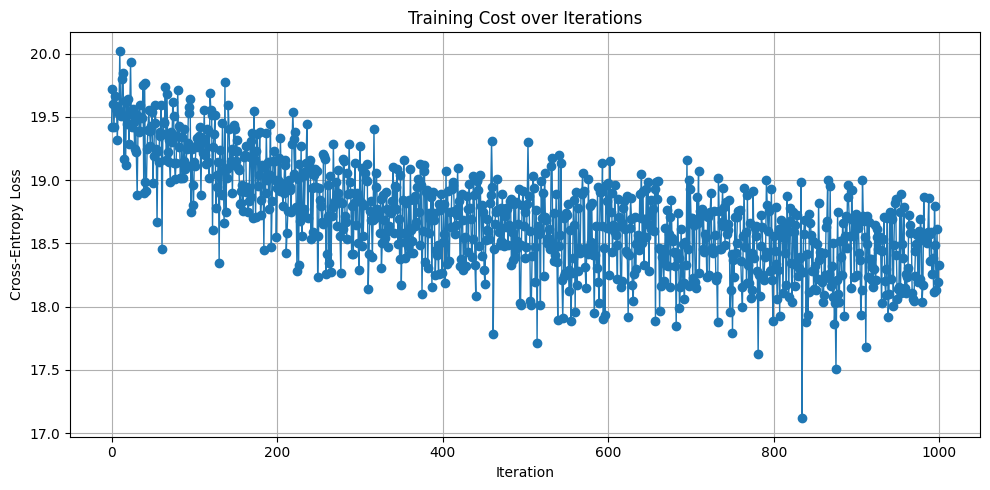

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cost_log, marker='o', linewidth=1)
plt.title("Training Cost over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# save the outputs for later
import pickle

model_outputs = {
    'W1': W1,
    'W2': W2,
    'b1': b1,
    'b2': b2,
    'cost_log': cost_log,
    'word2ind' : word2ind
}

with open("../model/cbow_model_outputs.pkl", "wb") as f:
    pickle.dump(model_outputs, f)

print("model saved to cbow_model_outputs.pkl")

# to load later
"""
with open("../model/cbow_model_outputs.pkl", "rb") as f:
    model_outputs = pickle.load(f)

#unpack
W1 = model_outputs['W1']
W2 = model_outputs['W2']
b1 = model_outputs['b1']
b2 = model_outputs['b2']
cost_log = model_outputs['cost_log']
word2ind = model_outputs.get('word2ind')

"""

model saved to cbow_model_outputs.pkl


'\nwith open("../model/cbow_model_outputs.pkl", "rb") as f:\n    model_outputs = pickle.load(f)\n\n#unpack\nW1 = model_outputs[\'W1\']\nW2 = model_outputs[\'W2\']\nb1 = model_outputs[\'b1\']\nb2 = model_outputs[\'b2\']\ncost_log = model_outputs[\'cost_log\']\nword2ind = model_outputs.get(\'word2ind\')\n\n'

## Using CBOW Embeddings for Sentiment Classification

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# convert reviews to avg word vectors using W1
def review_to_avg_vector(review, word2ind, W1):
    V = W1.shape[1]
    vectors = [W1[:, word2ind[word]] for word in review if word in word2ind]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(W1.shape[0])

# avg vectors for each review
X = np.array([